# Regresion Basica: Predecir eficiencia de gasolina

Este libro usa el set de datos clasico [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) y construye un modelo para predecir el consumo de vehiculos de 1970 y 1980. Para hacer esto proveeremos el modelo con una descripcion de muchos automoviles de ese periodo. Esta descripcion incluye atributos como: Cilindros, desplazamiento, potencia y peso.

El objetivo de este ejercicio es predecir el target miles per galon (MPG), que vendría a representar las millas por galón de combustible.

Este ejemplo usa el API `tf.keras` , revise [Esta Guia](https://www.tensorflow.org/guide/keras) para obtener mas detalles.

In [15]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


## El set de Datos de MPG

El set de datos esta disponible de el siguiente repositorio [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/).

### Obtenga los datos
Primero descargue el set de datos.

In [16]:
dataset_path = keras.utils.get_file("auto-mpg.data",
"http://archive.ics.uci.edu/ml/machine-learning-datasets/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\Admin\\.keras\\datasets\\auto-mpg.data'

In [17]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Importelo usando pandas.

In [18]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


### Limpia los datos

Trata los missings y variables categóricas

In [19]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [20]:
dataset = dataset.dropna()

In [21]:
# La columna de `"Origin"` realmente es categorica, no numerica. Entonces conviertala a un "one-hot":
origin = dataset.pop("Origin")

In [22]:
dataset['USA'] = (origin == 1)*1
dataset["Europe"] = (origin == 2)*1
dataset["Japan"] = (origin == 3)*1

In [23]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0


### Divide los datos en train y test

Ahora divida el set de datos en un set de entrenamiento y otro de pruebas. 80% para entrenamiento

Usaremos el set de pruebas en la evaluacion final de nuestro modelo.

NOTA: El resultado tienen que ser dos datasets

In [24]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

### Inspecciona los datos

Revise rapidamente la distribucion conjunta del dataset de entrenamiento mediante un grid de gráficos

In [25]:
train_dataset.columns

Index(['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'USA', 'Europe', 'Japan'],
      dtype='object')

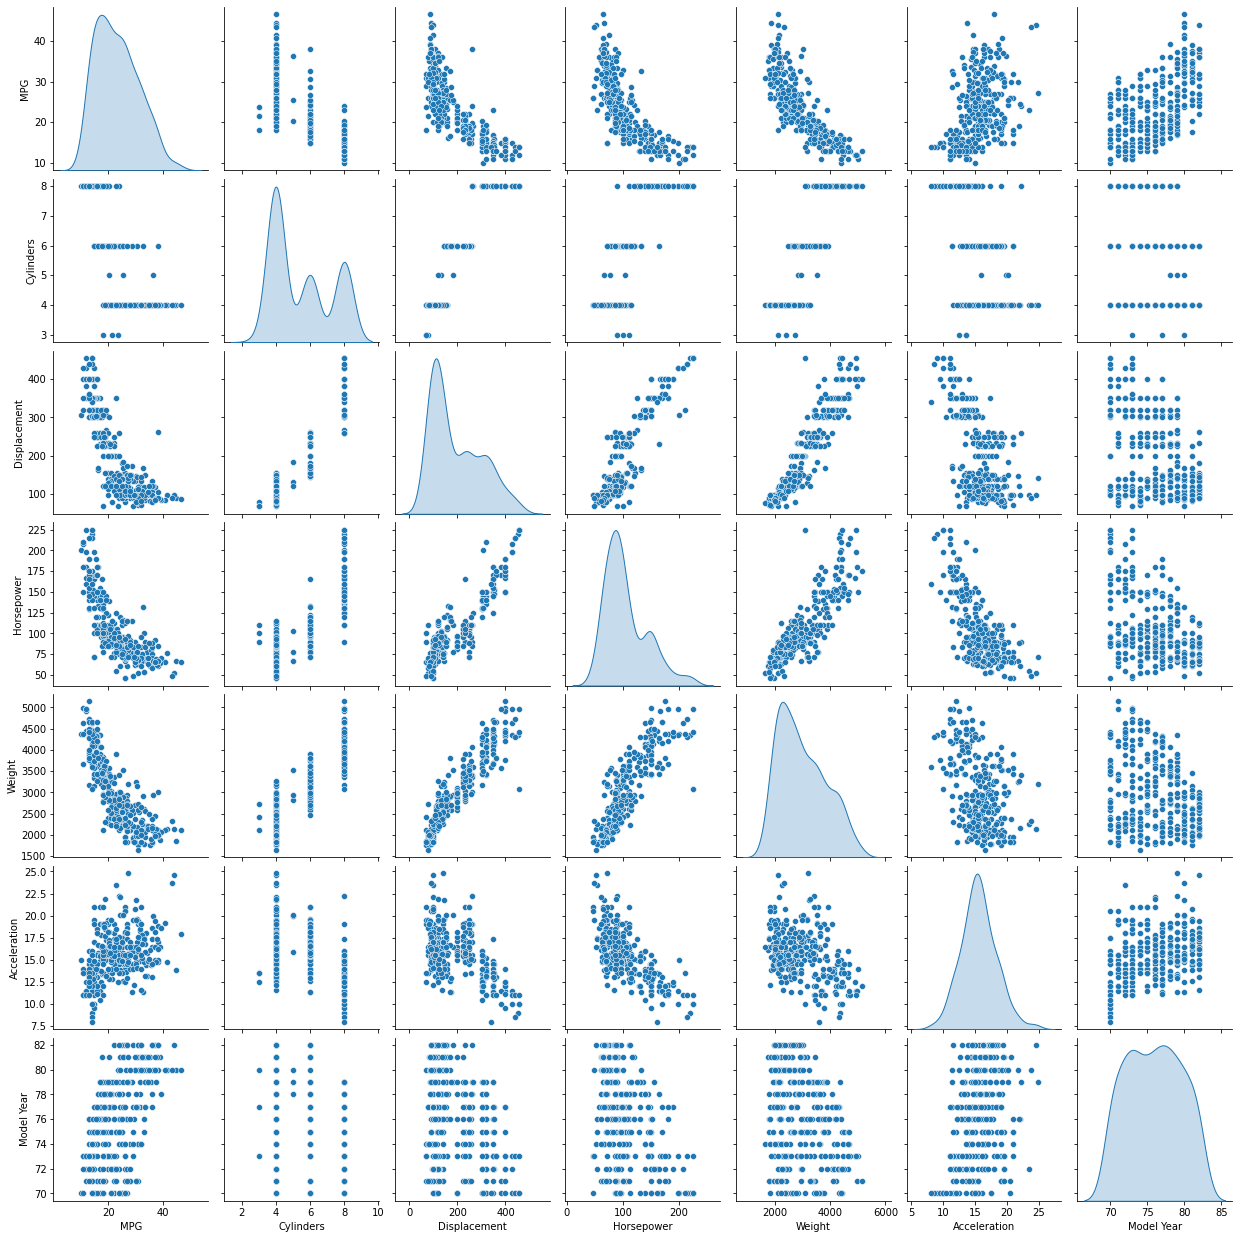

In [26]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement',
                            'Horsepower', 'Weight',
                           'Acceleration', 'Model Year']],
            diag_kind = 'kde');

Tambien revise las estadisticas generales:

In [27]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separa las features del target

Separe el target de las features.

In [28]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Estandariza los datos

Es una buena práctica estandarizar funciones que utilizan diferentes escalas y rangos. Aunque el modelo podría converger sin estandarizar, dificulta el entrenamiento y hace que el modelo resultante dependa de la elección de las unidades utilizadas en la entrada.

In [29]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_train_data.shape)
print(normed_test_data.shape)

(314, 9)
(78, 9)


Estos datos estandarizados es lo que usaremos para entrenar el modelo.

## El modelo

### Construye el modelo

Construyamos nuestro modelo. Aquí, utilizaremos un modelo `secuencial` con dos capas ocultas densamente conectadas y una capa de salida que devuelve un único valor continuo.

Por tanto, tendrá tres capas. Una de entrada con activación relu. Otra hidden layer con activación relu y la de salida de regresión, que se compondrá de una única neurona. Pon las neuronas que consideres para las dos primeras capas.

Para el compile utiliza un loss='mse'.

optimizer = `tf.keras.optimizers.RMSprop(0.001)`

Y en metrics añade en una lista el `mae` y `mse`.

In [30]:
model = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1)
])

model.compile(loss = 'mse',
             optimizer = tf.keras.optimizers.RMSprop(0.001),
             metrics = ['mae', 'mse'])

### Inspeccione el modelo

Use el método `.summary` para imprimir una descripción simple del modelo

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Entrenar el modelo

Entrene el modelo para 1000 epochs y guarda los resultados del entrenamiento en una variable llamada `history`.
Emplea en el entrenamiento un 20% de los datos para validación, mediante el argumento `validation_split`.

NOTA: recuerda usar los datos normalizados.

In [32]:
history = model.fit(
    normed_train_data,
    train_labels,
    epochs = 1000,
    validation_split = 0.2,
    verbose=0
)

Visualice el progreso de entrenamiento del modelo usando las estadísticas almacenadas en el objeto `history`.

In [33]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.470024,1.013863,2.470024,10.044833,2.514640,10.044833,995
996,2.467595,0.999091,2.467595,10.103435,2.528649,10.103435,996
997,2.688823,1.036516,2.688823,10.348848,2.431085,10.348848,997
998,2.458025,0.992922,2.458025,9.997949,2.430931,9.997949,998
999,2.506168,1.025518,2.506168,10.281777,2.448220,10.281777,999


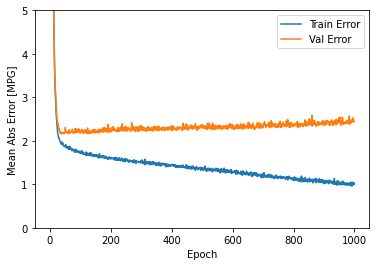

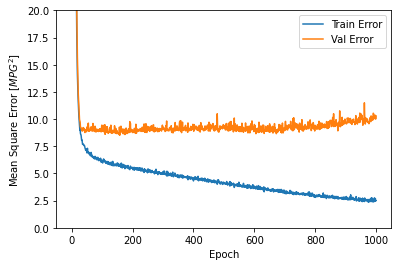

In [34]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

¿Alguna conclusión respecto a este gráfico?

Añade un early stopping al modelo. Pon el argumento `callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]` dentro del fit().

Después del entrenamiento utiliza la función del apartado anterior `plot_history(history)`.

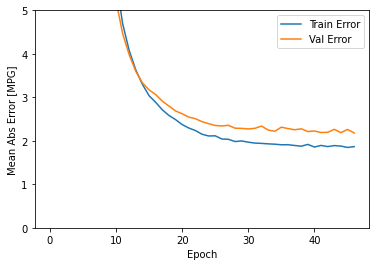

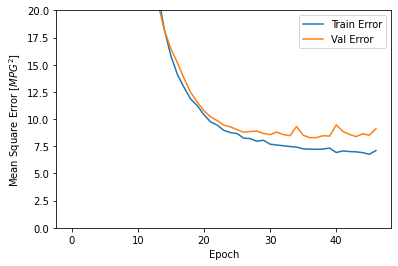

In [35]:
model = keras.Sequential([
    layers.Dense(64, activation = 'relu', input_shape = [len(train_dataset.keys())]),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(1)
])

model.compile(loss = 'mse',
             optimizer = tf.keras.optimizers.RMSprop(0.001),
             metrics = ['mae', 'mse'])

history = model.fit(
    normed_train_data,
    train_labels,
    epochs = 1000,
    validation_split = 0.2,
    verbose=0,
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)]
)

plot_history(history)

Interpreta el gráfico

Veamos qué tan bien generaliza el modelo al usar el conjunto de **test**. Esto nos dice qué tan bien podemos esperar que el modelo prediga cuándo lo usamos en el mundo real. Utiliza el método `evaluate` con los datos de test normalizados y sus labels.

Con el método evaluate devolverá tres valores: loss, mae y mse.

In [36]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels)
mae

3/3 [==============================] - 0s 3ms/step - loss: 6.3016 - mae: 1.9970 - mse: 6.3016


1.996954083442688

Ahora prueba el modelo. Coge 10 ejemplos de train y llama a` model.predict`.

In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[30.52259 ],
       [24.75671 ],
       [12.921304],
       [37.94598 ],
       [35.96834 ],
       [21.27667 ],
       [37.990124],
       [31.26849 ],
       [19.238178],
       [25.991283]], dtype=float32)

In [38]:
train_labels[:10]

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
257    19.4
310    38.1
328    30.0
125    20.0
108    20.0
Name: MPG, dtype: float64

### Haz Predicciones

Dibuja en un scatter plot las predicciones de test vs sus true labels.

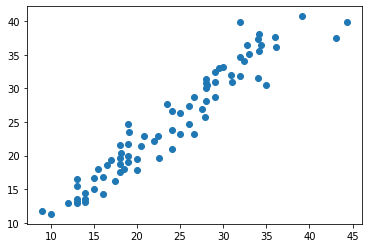

In [39]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions);

Parece que nuestro modelo predice razonablemente bien. Echemos un vistazo a la distribución de errores.

Representa los residuos en un histograma

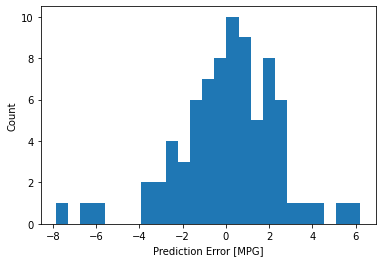

In [25]:
error = test_predictions - test_labels
plt.hist(error);

No es del todo gaussiano, pero podríamos esperar eso porque el número de muestras es muy pequeño.

## Conclusion

Este cuaderno introdujo algunas técnicas para manejar un problema de regresión.

* El error cuadrático medio (MSE) es una función de pérdida común utilizada para problemas de regresión (se utilizan diferentes funciones de pérdida para problemas de clasificación).
* Del mismo modo, las métricas de evaluación utilizadas para la regresión difieren de la clasificación. Una métrica de regresión común es el error absoluto medio (MAE).
* Cuando las características de datos de entrada numéricos tienen valores con diferentes rangos, cada característica debe escalarse independientemente al mismo rango.
* Si no hay muchos datos de entrenamiento, una técnica es preferir una red pequeña con pocas capas ocultas para evitar el sobreajuste.
* La detención temprana es una técnica útil para evitar el sobreajuste.